# Language Modeling


Let's try the language modeling task by using chariot and Tensorflow.

* Download the WikiText2 dataset by chazutsu.
* Preprocess WikiText2 by chariot.
* Make model by TensorFlow (use tf.keras).
* Train & evaluate the model.

This tutorial needs following libraries.

* chazutsu
* tensorflow
* matplotlib


## Prepare the packages

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def set_path():
    if "../" not in sys.path:
        sys.path.append("../")
    root_dir = Path.cwd()
    return root_dir

ROOT_DIR = set_path()

## Download the Language Modeling Data

In [4]:
import chazutsu
from chariot.storage import Storage

storage = Storage.setup_data_dir(ROOT_DIR)
r = chazutsu.datasets.WikiText2().download(storage.data_path("raw"))

Read resource from the existed resource(if you want to retry, set force=True).


In [5]:
r.train_data().head(3)

,sentence
0,= Valkyria Chronicles III =
1,Senjō no Valkyria 3 : <unk> Chronicles ( Japa...
2,"The game began development in 2010 , carrying..."


## Preprocess the review text by chariot.

### Make preprocessor

In [6]:
import chariot.transformer as ct
from chariot.preprocessor import Preprocessor


lm_processor = Preprocessor(
                    text_transformers=[
                        ct.text.UnicodeNormalizer(),
                        ct.text.LowerNormalizer()
                    ],
                    tokenizer=ct.Tokenizer(lang=None),
                    vocabulary=ct.Vocabulary(min_df=5))

preprocessed = lm_processor.fit_transform(r.valid_data())

In [7]:
print(len(lm_processor.vocabulary.get()))

4321


## Make model by TensorFlow

In [8]:
from tensorflow.python import keras as K


vocab_size = lm_processor.vocabulary.count
embedding_size = 100
hidden_size = 100
batch_size = 20
sequence_length = 35


def make_model(vocab_size, embedding_size, hidden_size, dropout=0.5):
    initializer = K.initializers.RandomUniform(minval=-0.1, maxval=0.1)
    model = K.Sequential()
    model.add(K.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size,
                                 embeddings_initializer=initializer))
    model.add(K.layers.Dropout(dropout))
    model.add(K.layers.LSTM(hidden_size))
    model.add(K.layers.Dropout(dropout))
    model.add(K.layers.Dense(vocab_size, activation="softmax",
                             kernel_initializer=initializer))
    return model


def perplexity(y_true, y_pred):
    cross_entropy = K.backend.mean(K.backend.sparse_categorical_crossentropy(y_true, y_pred))
    perplexity = K.backend.exp(cross_entropy)
    return perplexity

In [9]:
model = make_model(vocab_size, embedding_size, hidden_size)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=[perplexity])

## Train the Model

In [10]:
class ReportCallback(K.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        print("Epoch {}: perplexity={}, loss={}, val_perplexity={}, val_loss={},".format(
                epoch, logs["perplexity"], logs["loss"], logs["val_perplexity"], logs["val_loss"]))

In [11]:
from chariot.feeder import LanguageModelFeeder


generator_step = {"valid":{}, "test": {}}
for kind in generator_step:
    if kind == "valid":
        data = preprocessed
    else:
        data = lm_processor.transform(r.test_data())

    feeder = LanguageModelFeeder({"sentence": ct.formatter.ShiftGenerator()})
    steps_per_epoch, generator = feeder.make_generator(data, batch_size=batch_size,
                                                       sequence_length=sequence_length,
                                                       sequencial=False)
    generator_step[kind]["s"] = steps_per_epoch
    generator_step[kind]["g"] = generator()

In [12]:
metrics = model.fit_generator(generator_step["valid"]["g"], generator_step["valid"]["s"],
                              validation_data=generator_step["test"]["g"], validation_steps=generator_step["valid"]["s"],
                              epochs=10, verbose=0, callbacks=[ReportCallback()])

c:\users\ico\documents\works\chariot\venv\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0: perplexity=244.97457648294812, loss=5.10353489501288, val_perplexity=120.71387894057659, val_loss=4.472375059601565,
Epoch 1: perplexity=177.78400755876103, loss=4.843199212954995, val_perplexity=107.5903396497481, val_loss=4.346049527629241,
Epoch 2: perplexity=157.48715339026757, loss=4.719259876821151, val_perplexity=102.40556391636886, val_loss=4.300950700740463,
Epoch 3: perplexity=143.58449326902257, loss=4.630188016067141, val_perplexity=98.6503278849318, val_loss=4.249957397027923,
Epoch 4: perplexity=134.90386063745822, loss=4.569199797293468, val_perplexity=93.19303302265078, val_loss=4.199935515224193,
Epoch 5: perplexity=127.13348013948459, loss=4.514451115971114, val_perplexity=94.3414631057366, val_loss=4.196338434001432,
Epoch 6: perplexity=121.88018428207451, loss=4.475763822087469, val_perplexity=91.68357086200591, val_loss=4.172137596248337,
Epoch 7: perplexity=117.93703318940308, loss=4.441510927777828, val_perplexity=88.59471916979483, val_loss=4.1427416592

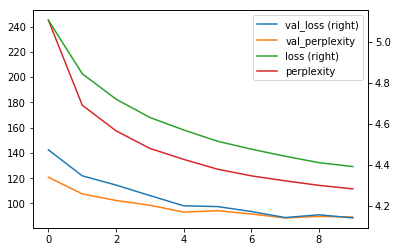

In [13]:
result = pd.DataFrame.from_dict(metrics.history)
result.plot.line(secondary_y=["loss", "val_loss"])

## Try generating the Text

In [14]:
def generate_text(seed_text, lm_processor, model, sequence_length=10, iteration=20):
    preprocessed = lm_processor.transform([seed_text])[0]

    def pad_sequence(tokens, length):
        if len(tokens) < length:
            pad_size = length - len(tokens)
            return tokens + [lm_processor.vocabulary.pad] * pad_size
        elif len(tokens) > length:
            return tokens[-length:]
        else:
            return tokens

    for _ in range(iteration):
        x = pad_sequence(preprocessed, sequence_length)
        y = model.predict([x])[0]
        w = np.random.choice(np.arange(len(y)), 1, p=y)[0]
        preprocessed.append(w)
    
    decoded = lm_processor.inverse_transform([preprocessed])
    text = " ".join(decoded[0])

    return text

In [15]:
generate_text("when you", lm_processor, model)

'when you starr @@UNKNOWN@@ year disc [ @@UNKNOWN@@ nine arm @@UNKNOWN@@ believing intelligence writings were group edwards had era his @@UNKNOWN@@ that'

In [16]:
generate_text("i wish to", lm_processor, model)

"i wish @@UNKNOWN@@ have performed were 'm states contain was tour @@UNKNOWN@@ @@UNKNOWN@@ been @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@ white @@UNKNOWN@@ @@UNKNOWN@@ @@UNKNOWN@@"